<a href="https://colab.research.google.com/github/maria-igntv/speech_technology_mipt_vk/blob/main/HW2_Denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Взять произвольную аудиозапись. Получить ее мел спектрограмму (используя вашу реализацию!). Прогнать любой алгоритм шумоподавления (или написать свой!). И получить мелспектрограмму полученного сигнала. Посчитать метрики до и после. Выбор метрик зависит от вас - ориентируйтесь на лекцию.

In [1]:
from IPython.display import Audio, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import warnings
warnings.filterwarnings("ignore")

### 1. Загрузка аудио + шум

In [2]:
audio_path = librosa.ex('trumpet')
clean_wav, sr = librosa.load(audio_path, sr=None)

def add_noise(signal, snr_db=5):
    """Добавляет белый шум с заданным SNR"""
    signal_power = np.mean(signal**2)
    noise = np.random.normal(0, 1, len(signal))
    noise_power = np.mean(noise**2)
    scale_factor = np.sqrt(signal_power / (noise_power * 10**(snr_db/10)))
    return signal + noise * scale_factor

noisy_wav = add_noise(clean_wav, snr_db=5)

print("Зашумленное аудио")
display(Audio(noisy_wav, rate=sr))


Зашумленное аудио


In [3]:
def spectral_subtraction_denoise(noisy_signal, sr):
    """
    Простой алгоритм Spectral Subtraction для шумоподавления
    """

    n_fft = 2048 # STFT параметры
    hop_length = 512

    stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length) # Вычисляем STFT
    magnitude = np.abs(stft)
    phase = np.angle(stft)

    noise_frames = 5
    noise_estimate = np.mean(np.abs(stft[:, :noise_frames])**2, axis=1, keepdims=True)

    # Spectral subtraction
    alpha = 2.0
    beta = 0.01

    enhanced_magnitude_squared = np.maximum(magnitude**2 - alpha * noise_estimate, beta * noise_estimate)
    enhanced_magnitude = np.sqrt(enhanced_magnitude_squared)

    # Восстанавливаем сигнал
    enhanced_stft = enhanced_magnitude * np.exp(1j * phase)
    enhanced_signal = librosa.istft(enhanced_stft, hop_length=hop_length)

    if len(enhanced_signal) > len(noisy_signal):
        enhanced_signal = enhanced_signal[:len(noisy_signal)]
    else:
        enhanced_signal = np.pad(enhanced_signal, (0, len(noisy_signal) - len(enhanced_signal)))

    return enhanced_signal

# denoize
enhanced_wav = spectral_subtraction_denoise(noisy_wav, sr)

print("После шумоподавления:")
display(Audio(enhanced_wav, rate=sr))

После шумоподавления:


### 2. Mel спектрограмма (из HW1)

In [10]:
def compute_mel_spectrogram(wav, sr, n_fft=2048, hop_length=512, n_mels=128):

    if len(wav) < n_fft:
        wav = np.pad(wav, (0, n_fft - len(wav)), mode='constant')
    else:
        extra = (len(wav) - n_fft) % hop_length
        if extra != 0:
            wav = np.pad(wav, (0, hop_length - extra), mode='constant')

    def frame_signal(signal, frame_length, hop_length):
        n_frames = 1 + (len(signal) - frame_length) // hop_length
        frames = np.lib.stride_tricks.sliding_window_view(signal, window_shape=frame_length)[::hop_length]
        return frames[:n_frames]

    frames = frame_signal(wav, n_fft, hop_length)
    window = np.hanning(n_fft)
    windowed_frames = frames * window
    stft_matrix = np.fft.rfft(windowed_frames, n=n_fft)
    power_spectrogram = np.abs(stft_matrix) ** 2

    # Mel filterbank
    fmin, fmax = 0, sr // 2

    def hz_to_mel(hz): return 2595 * np.log10(1 + hz / 700)
    def mel_to_hz(mel): return 700 * (10 ** (mel / 2595) - 1)

    mel_min, mel_max = hz_to_mel(fmin), hz_to_mel(fmax)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = mel_to_hz(mel_points)

    bin_width = sr / n_fft
    fft_bins = np.floor(hz_points / bin_width).astype(int)
    fft_bins = np.clip(fft_bins, 0, stft_matrix.shape[1] - 1)

    mel_filterbank = np.zeros((n_mels, stft_matrix.shape[1]))
    for m in range(n_mels):
        left, center, right = fft_bins[m], fft_bins[m+1], fft_bins[m+2]
        if center > left:
            mel_filterbank[m, left:center] = (np.arange(left, center) - left) / (center - left)
        if right > center:
            mel_filterbank[m, center:right] = (right - np.arange(center, right)) / (right - center)

    mel_spectrogram = np.dot(mel_filterbank, power_spectrogram.T).T
    return np.log(mel_spectrogram + 1e-10)

# Вычисляем мел-спектрограммы до и после
clean_mel_spec = compute_mel_spectrogram(clean_wav, sr)
noisy_mel_spec = compute_mel_spectrogram(noisy_wav, sr)
enhanced_mel_spec = compute_mel_spectrogram(enhanced_wav, sr)

print(f"Clean: {clean_mel_spec.shape}, \nNoisy: {noisy_mel_spec.shape},\nEnhanced: {enhanced_mel_spec.shape}")



Clean: (227, 128), 
Noisy: (227, 128),
Enhanced: (227, 128)


### 3. Вычисление метрик

In [12]:
def calculate_sisdr(clean, enhanced, epsilon=1e-8):
    """SI-SDR"""
    clean = clean - np.mean(clean)
    enhanced = enhanced - np.mean(enhanced)
    alpha = np.dot(enhanced, clean) / (np.dot(clean, clean) + epsilon)
    target = alpha * clean
    distortion = enhanced - target
    sisdr = 10 * np.log10(np.dot(target, target) / (np.dot(distortion, distortion) + epsilon) + epsilon)
    return sisdr

def calculate_snr(clean, noisy):
    """SNR"""
    signal_power = np.mean(clean**2)
    noise_power = np.mean((noisy - clean)**2)
    return 10 * np.log10(signal_power / (noise_power + 1e-10))

def calculate_spectral_distance(clean_spec, processed_spec):
    """Spectral Distance"""
    return np.mean(np.abs(clean_spec - processed_spec))


In [13]:
sisdr_noisy = calculate_sisdr(clean_wav, noisy_wav)
sisdr_enhanced = calculate_sisdr(clean_wav, enhanced_wav)

snr_noisy = calculate_snr(clean_wav, noisy_wav)
snr_enhanced = calculate_snr(clean_wav, enhanced_wav)

spec_dist_noisy = calculate_spectral_distance(clean_mel_spec, noisy_mel_spec)
spec_dist_enhanced = calculate_spectral_distance(clean_mel_spec, enhanced_mel_spec)

metrics_df = pd.DataFrame({
    'Метрика': ['SI-SDR [dB]', 'SNR [dB]', 'Spectral Distance'],
    'До шумоподавления': [sisdr_noisy, snr_noisy, spec_dist_noisy],
    'После шумоподавления': [sisdr_enhanced, snr_enhanced, spec_dist_enhanced],
    'Дельта метрик, db': [sisdr_enhanced - sisdr_noisy,
                  snr_enhanced - snr_noisy,
                  spec_dist_noisy - spec_dist_enhanced]
})

metrics_df

,Метрика,До шумоподавления,После шумоподавления,"Дельта метрик, db"
0,SI-SDR [dB],4.989479,5.788887,0.799408
1,SNR [dB],5.000000,6.769425,1.769425
2,Spectral Distance,9.847897,8.229767,1.618130


### 4. Визуализация

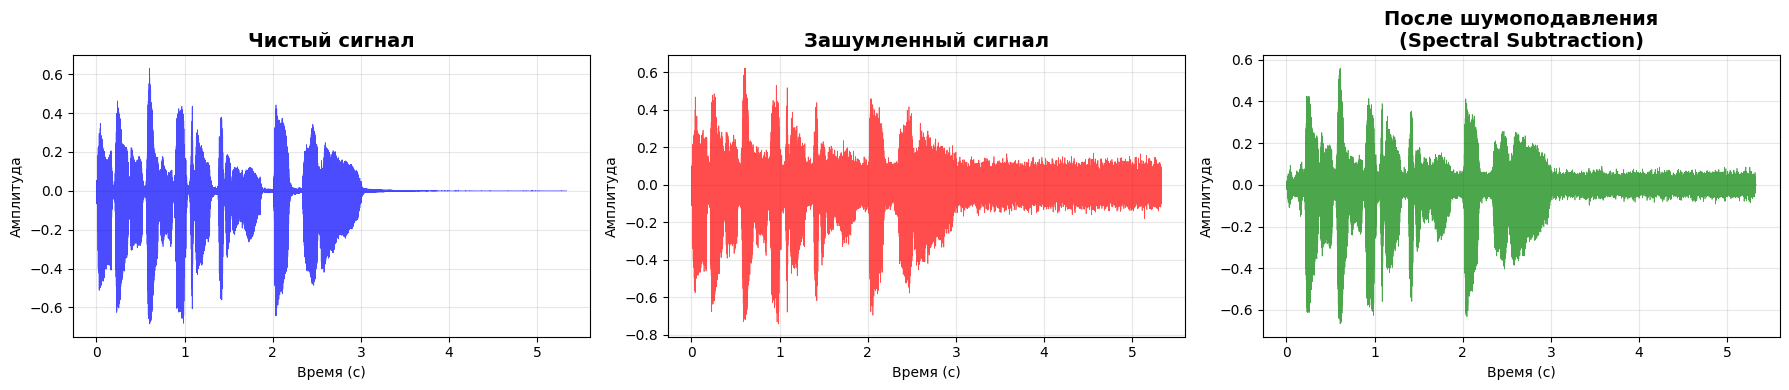

In [14]:
fig_signals, axes_signals = plt.subplots(1, 3, figsize=(18, 4))

t = np.arange(len(clean_wav)) / sr

axes_signals[0].plot(t, clean_wav, 'b', alpha=0.7, linewidth=0.5)
axes_signals[0].set_title('Чистый сигнал', fontsize=14, fontweight='bold')
axes_signals[0].set_xlabel('Время (с)')
axes_signals[0].set_ylabel('Амплитуда')
axes_signals[0].grid(True, alpha=0.3)

axes_signals[1].plot(t, noisy_wav, 'r', alpha=0.7, linewidth=0.5)
axes_signals[1].set_title('Зашумленный сигнал', fontsize=14, fontweight='bold')
axes_signals[1].set_xlabel('Время (с)')
axes_signals[1].set_ylabel('Амплитуда')
axes_signals[1].grid(True, alpha=0.3)

axes_signals[2].plot(t, enhanced_wav, 'g', alpha=0.7, linewidth=0.5)
axes_signals[2].set_title('После шумоподавления\n(Spectral Subtraction)', fontsize=14, fontweight='bold')
axes_signals[2].set_xlabel('Время (с)')
axes_signals[2].set_ylabel('Амплитуда')
axes_signals[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

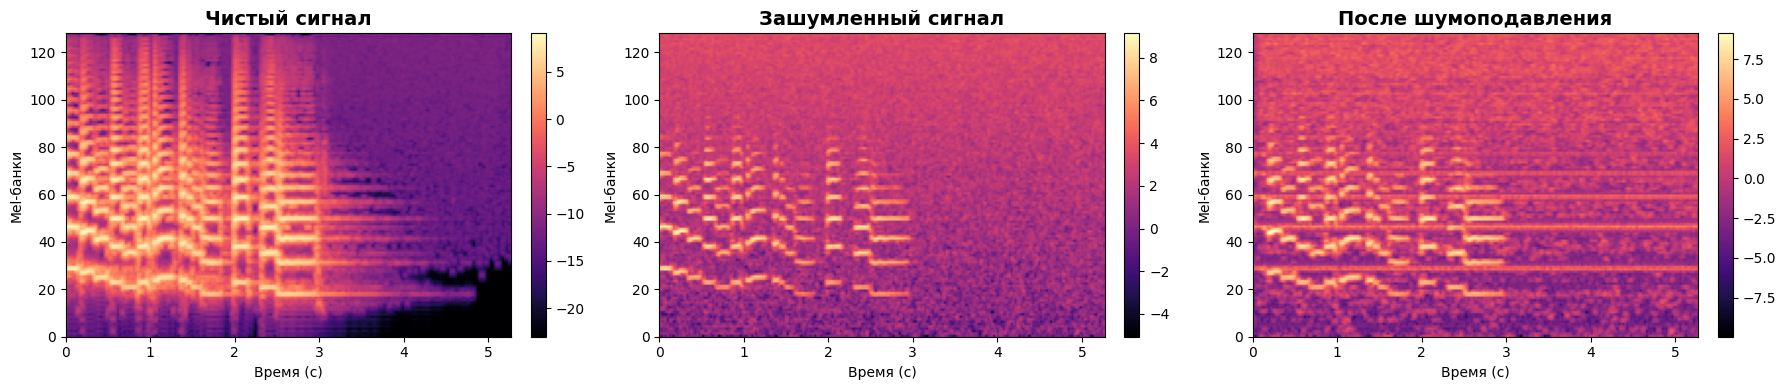

In [15]:
fig_specs, axes_specs = plt.subplots(1, 3, figsize=(18, 4))

def plot_mel_spec(spec, ax, title, sr=sr, hop_length=512):
    im = ax.imshow(spec.T, aspect='auto', origin='lower',
                   extent=[0, len(spec)*hop_length/sr, 0, 128], cmap='magma')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Время (с)')
    ax.set_ylabel('Mel-банки')
    return im

im1 = plot_mel_spec(clean_mel_spec, axes_specs[0], 'Чистый сигнал')

im2 = plot_mel_spec(noisy_mel_spec, axes_specs[1], 'Зашумленный сигнал')

im3 = plot_mel_spec(enhanced_mel_spec, axes_specs[2], 'После шумоподавления')

plt.colorbar(im1, ax=axes_specs[0], fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axes_specs[1], fraction=0.046, pad=0.04)
plt.colorbar(im3, ax=axes_specs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()